# Predictive Analysis: Weather and ERCOT Prices

![Power Lines](https://www.fae-group.com/images/applicazioni/header/Applications_power_lines_fae.jpg)

The data for this analysis comes from:
- [Weather](http://mrcc.isws.illinois.edu/) - Midwestern Regional Climate Center: MRCC
- [Day Ahead Pricing](http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13060&reportTitle=Historical%20DAM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey) - ERCOT Market Prices
- [RTM Pricing](http://mis.ercot.com/misapp/GetReports.do?reportTypeId=13061&reportTitle=Historical%20RTM%20Load%20Zone%20and%20Hub%20Prices&showHTMLView=&mimicKey) - ERCOT Market Prices

## Question
1. Is there a correlation between weather and electricty pricing.
2. Is the correlation stronger between Spot Pricing or Day ahead pricing?
3. Can the correlation be used with a neural network to generate price prediction?
4. If not, can the correlation be used to generate a pricing direction signal?

## Methodology
1. Download data from source sites
2. Convert to CSV using VBA in excel
3. Aggregate CSV files to single data frame for:
  - Spot Pricing
  - DA Pricing
  - Weather
4. Clean data and create calculated features
5. Create Neural Net in Tensorflow
6. Train and analyze
7. Setup trained model as a webservice
8. Feed forecast data to model to generate price predictions

![Heat Map of Texas](http://www.ercot.com/content/wcm/landing_pages/88828/Weather_Map.png)

### Import Components and Data

In [121]:
# import packages
import matplotlib.pyplot as plt
import datetime
import pandas as pd
import numpy as np

# Data ingestion done in separate python scripts
import load_spot_pricing_data as sp_pricing
import load_day_ahead_pricing_data as da_pricing
import load_weather_data as weather

In [138]:
# Spot Pricing DataFrame
sp_houston = sp_pricing.spot_pricing_df[sp_pricing.spot_pricing_df['Settlement Point Name'] == 'HB_HOUSTON'].copy()
sp_houston = sp_houston[sp_houston['Delivery Interval'] <= 1]
sp_houston = sp_houston.sort_values(by=['Delivery Date', 'Delivery Hour']).reset_index(drop=True)
sp_houston['Hour Number'] = sp_houston.index
sp_houston['Settlement Point Price'] = pd.to_numeric(sp_houston['Settlement Point Price'], errors='coerce')
sp_houston['SPP 10 DMA'] = sp_houston['Settlement Point Price'].rolling(window=240).mean()
sp_houston['SPP 10 Mean Dev'] = sp_houston['Settlement Point Price'] - sp_houston['SPP 10 DMA']

# Day Ahead Pricing DataFrame
da_houston = da_pricing.day_ahead_pricing_df[da_pricing.day_ahead_pricing_df['Settlement Point'] == 'HB_HOUSTON'].copy()
da_houston = da_houston.sort_values(by=['Delivery Date', 'Hour Ending']).reset_index(drop=True)
da_houston['Hour Number'] = da_houston.index
da_houston['Settlement Point Price'] = pd.to_numeric(da_houston['Settlement Point Price'], errors='coerce')
da_houston = da_houston.fillna(method='bfill')
da_houston['SPP 10 DMA'] = da_houston['Settlement Point Price'].rolling(window=240).mean()
da_houston['SPP 10 Mean Dev'] = da_houston['Settlement Point Price'] - da_houston['SPP 10 DMA']
da_houston['SPP 30 DMA'] = da_houston['Settlement Point Price'].rolling(window=720).mean()
da_houston['SPP 30 Mean Dev'] = da_houston['Settlement Point Price'] - da_houston['SPP 30 DMA']

# Weather DataFrame
mod_weather_df = weather.weather_df
mod_weather_df = mod_weather_df.sort_values(by=['Date']).reset_index(drop=True)
mod_weather_df = mod_weather_df.select_dtypes(['float', 'int'])
mod_weather_df = mod_weather_df.drop(['PeakWindGust', 'LowCloudHt', 'MedCloudHt', 'HighCloudHt', 'Visibility', 'WindDirection', 'SeaLevPress', 'Precip'], axis=1)
mod_weather_df = mod_weather_df.fillna(method='bfill')
mod_weather_df['Temp 10 DMA'] = mod_weather_df['Temp'].rolling(window=240).mean()
mod_weather_df['Temp 10 Mean Dev'] = mod_weather_df['Temp'] - mod_weather_df['Temp 10 DMA']
mod_weather_df['Temp 30 DMA'] = mod_weather_df['Temp'].rolling(window=720).mean()
mod_weather_df['Temp 30 Mean Dev'] = mod_weather_df['Temp'] - mod_weather_df['Temp 30 DMA']
mod_weather_df['AtmPress 10 DMA'] = mod_weather_df['AtmPress'].rolling(window=240).mean()
mod_weather_df['AtmPress 10 Mean Dev'] = mod_weather_df['AtmPress'] - mod_weather_df['AtmPress 10 DMA']
mod_weather_df['AtmPress 30 DMA'] = mod_weather_df['AtmPress'].rolling(window=720).mean()
mod_weather_df['AtmPress 30 Mean Dev'] = mod_weather_df['AtmPress'] - mod_weather_df['AtmPress 30 DMA']

### Data Features

In [139]:
sp_joined = mod_weather_df[['Temp',
                          'Temp 10 DMA',
                          'Temp 10 Mean Dev',
                          'AtmPress 10 Mean Dev']].join(sp_houston[['Settlement Point Price', 'SPP 10 DMA', 'SPP 10 Mean Dev']])

In [140]:
print(sp_joined.loc[3600:5600, ['Temp 10 Mean Dev',
                                'Temp 10 DMA',
                                'AtmPress 10 Mean Dev',
                                'SPP 10 Mean Dev', 
                                'Settlement Point Price']].corr()['Settlement Point Price'])

Temp 10 Mean Dev         -0.037532
Temp 10 DMA               0.032077
AtmPress 10 Mean Dev      0.043609
SPP 10 Mean Dev           0.990598
Settlement Point Price    1.000000
Name: Settlement Point Price, dtype: float64


**While there is some correlation between the 'Settlement Point Price' and the other data fields. This does not look like it is storng enough to make any predictions.**

In [141]:
da_joined = mod_weather_df[['Temp',
                            'AtmPress',
                            'Temp 10 DMA',
                            'Temp 30 DMA',
                            'AtmPress 10 DMA',
                            'AtmPress 30 DMA',
                            'Temp 10 Mean Dev',
                            'Temp 30 Mean Dev',
                            'AtmPress 10 Mean Dev',
                            'AtmPress 30 Mean Dev']].join(da_houston[['Settlement Point Price', 'SPP 10 DMA', 'SPP 30 DMA']])

In [143]:
da_joined = da_joined.dropna(axis=0, how='any')
# da_joined[da_joined['Settlement Point Price'].isnull()]
# da_joined[da_joined['Settlement Point Price'].isnull()]

In [144]:
print(da_joined.loc[:, ['AtmPress',
                        'Temp',
                        'AtmPress 10 DMA',
                        'AtmPress 30 DMA',
                        'AtmPress 10 Mean Dev',
                        'AtmPress 30 Mean Dev',
                        'SPP 10 DMA',
                        'SPP 30 DMA',
                        'Temp 10 DMA',
                        'Temp 30 DMA',
                        'Temp 10 Mean Dev',
                        'Temp 30 Mean Dev',
                        'Settlement Point Price']].corr()['Settlement Point Price'])

AtmPress                  0.020932
Temp                     -0.061772
AtmPress 10 DMA           0.004819
AtmPress 30 DMA           0.006387
AtmPress 10 Mean Dev      0.020085
AtmPress 30 Mean Dev      0.019658
SPP 10 DMA                0.183513
SPP 30 DMA                0.154073
Temp 10 DMA              -0.018674
Temp 30 DMA              -0.016125
Temp 10 Mean Dev         -0.073709
Temp 30 Mean Dev         -0.073930
Settlement Point Price    1.000000
Name: Settlement Point Price, dtype: float64


In [145]:
# Min-Max Normalize Joined DataFrame
# da_joined = da_joined[np.abs(da_joined['Settlement Point Price']-da_joined['Settlement Point Price'].mean())<=(2*da_joined['Settlement Point Price'].std())]
da_joined = (da_joined-da_joined.min())/(da_joined.max()-da_joined.min())
da_joined['Settlement Point Price'] = da_joined.applymap(lambda x: np.log(x+1))

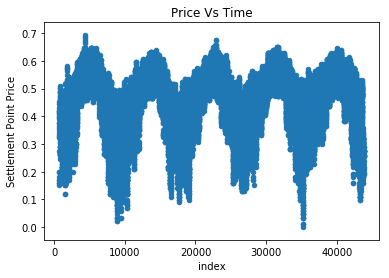

In [146]:
da_joined.reset_index().plot.scatter(x='index', y='Settlement Point Price', title='Price Vs Time')

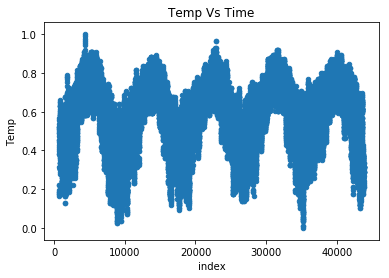

In [147]:
da_joined.reset_index().plot.scatter(x='index', y='Temp', title='Temp Vs Time')

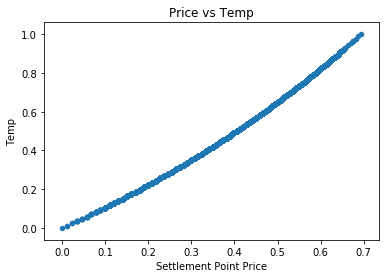

In [148]:
da_joined.reset_index().plot.scatter(x='Settlement Point Price', y='Temp', title='Price vs Temp')

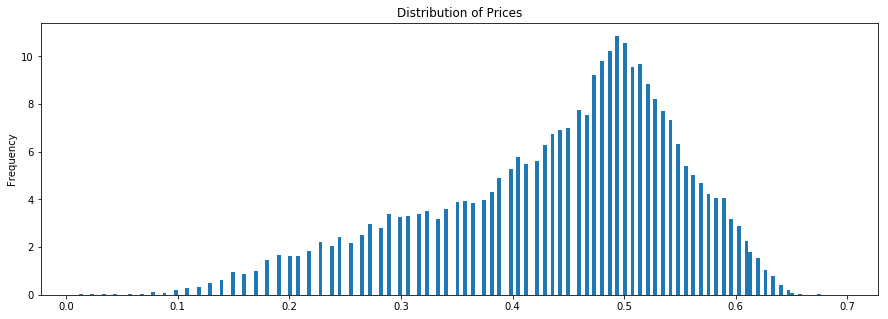

In [149]:
da_joined[da_joined["Settlement Point Price"] > 0]["Settlement Point Price"].plot.hist(bins=200, figsize=[15,5], density=True, title='Distribution of Prices')

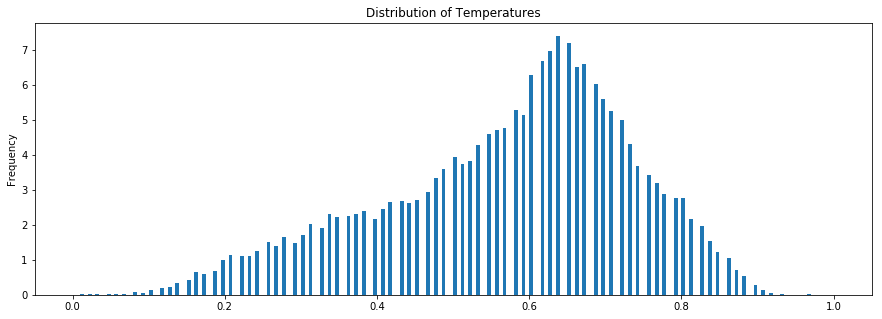

In [150]:
da_joined["Temp"].plot.hist(bins=200, figsize=[15,5], density=True, title='Distribution of Temperatures')

In [151]:
print(da_joined.loc[:, ['AtmPress',
                        'Temp',
                        'AtmPress 10 DMA',
                        'AtmPress 30 DMA',
                        'AtmPress 10 Mean Dev',
                        'AtmPress 30 Mean Dev',
                        'SPP 10 DMA',
                        'SPP 30 DMA',
                        'Temp 10 DMA',
                        'Temp 30 DMA',
                        'Temp 10 Mean Dev',
                        'Temp 30 Mean Dev',
                        'Settlement Point Price']].corr()['Settlement Point Price'])

AtmPress                 -0.570188
Temp                      0.997793
AtmPress 10 DMA          -0.499310
AtmPress 30 DMA          -0.625489
AtmPress 10 Mean Dev     -0.297189
AtmPress 30 Mean Dev     -0.290193
SPP 10 DMA               -0.096436
SPP 30 DMA               -0.121805
Temp 10 DMA               0.766118
Temp 30 DMA               0.736885
Temp 10 Mean Dev          0.605128
Temp 30 Mean Dev          0.643777
Settlement Point Price    1.000000
Name: Settlement Point Price, dtype: float64


### Prepping Data for training

In [152]:
import keras
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Activation
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [153]:
# Take a random sample for testing
sample = np.random.choice(da_joined.index, size=int(len(da_joined)*0.9), replace=False)
train_data = da_joined.loc[sample]
test_data = da_joined.drop(sample)
features = np.array(train_data.drop('Settlement Point Price', axis=1))
targets = np.array(train_data['Settlement Point Price'])
features_test =  np.array(test_data.drop('Settlement Point Price', axis=1))
targets_test = np.array(test_data['Settlement Point Price'])

#### Train and evaluate with simple MSE manual validation

In [154]:
##define base model
model = Sequential()
model.add(Dense(32, input_shape=[features.shape[1]], kernel_initializer='normal', activation='sigmoid'))
model.add(Dense(1, kernel_initializer='normal', activation="linear"))
sgd=keras.optimizers.SGD(lr=0.01)
model.compile(optimizer=sgd ,loss='mse',metrics=['mse'])

# Train Model
model.fit(features,targets, validation_data=[features_test, targets_test], batch_size=1, epochs=5, shuffle=False, verbose=1)

Train on 38780 samples, validate on 4309 samples
Epoch 1/5
38780/38780 [==============================] - 62s 2ms/step - loss: 0.0029 - mean_squared_error: 0.0029 - val_loss: 1.6504e-04 - val_mean_squared_error: 1.6504e-04
Epoch 2/5
38780/38780 [==============================] - 44s 1ms/step - loss: 9.0245e-05 - mean_squared_error: 9.0245e-05 - val_loss: 4.7438e-05 - val_mean_squared_error: 4.7438e-05
Epoch 3/5
38780/38780 [==============================] - 38s 985us/step - loss: 4.6042e-05 - mean_squared_error: 4.6042e-05 - val_loss: 3.8165e-05 - val_mean_squared_error: 3.8165e-05
Epoch 4/5
38780/38780 [==============================] - 39s 1ms/step - loss: 4.0893e-05 - mean_squared_error: 4.0893e-05 - val_loss: 3.5992e-05 - val_mean_squared_error: 3.5992e-05
Epoch 5/5
38780/38780 [==============================] - 38s 980us/step - loss: 3.9294e-05 - mean_squared_error: 3.9294e-05 - val_loss: 3.5111e-05 - val_mean_squared_error: 3.5111e-05


In [157]:
print(model.predict(features[2].reshape(-1,12)))
print(targets[2])

[[ 0.31389806]]
0.316337328212


#### Train and evaluate with Manual k-Fold Cross Validation

In [158]:
# define base model
def baseline_model():
    ##define base model
    model = Sequential()
    model.add(Dense(32, input_shape=[features.shape[1]], kernel_initializer='normal', activation='linear'))
    model.add(Dense(1, kernel_initializer='normal', activation="linear"))
    sgd=keras.optimizers.SGD(lr=0.01)
    model.compile(loss='mean_squared_error', optimizer=sgd, metrics=['mse'])
    return model

# fix random seed for reproducibility
seed = 7
np.random.seed(seed)
# evaluate model with standardized dataset
estimator = KerasRegressor(build_fn=baseline_model, nb_epoch=100, batch_size=5, verbose=1)

kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, features, targets, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Epoch 1/1
3878/3878 [==============================] - 1s 190us/step
Epoch 1/1
3878/3878 [==============================] - 1s 172us/step
Epoch 1/1
3878/3878 [==============================] - 1s 287us/step
Epoch 1/1
3878/3878 [==============================] - 1s 148us/step
Epoch 1/1
3878/3878 [==============================] - 1s 185us/step
Epoch 1/1
3878/3878 [==============================] - 1s 194us/step
Epoch 1/1
3878/3878 [==============================] - 2s 456us/step
Epoch 1/1
3878/3878 [==============================] - 1s 199us/step
Epoch 1/1
3878/3878 [==============================] - 1s 338us/step
Epoch 1/1
3878/3878 [==============================] - 1s 242us/step
Results: -0.00 (0.00) MSE


In [159]:
estimator.fit(features, targets, epochs=20, batch_size=5, verbose=1)

Epoch 1/20
38780/38780 [==============================] - 13s 334us/step - loss: 0.0014 - mean_squared_error: 0.0014
Epoch 2/20
38780/38780 [==============================] - 11s 287us/step - loss: 8.1315e-05 - mean_squared_error: 8.1315e-05
Epoch 3/20
38780/38780 [==============================] - 16s 423us/step - loss: 5.4484e-05 - mean_squared_error: 5.4484e-05
Epoch 4/20
38780/38780 [==============================] - 16s 406us/step - loss: 4.9920e-05 - mean_squared_error: 4.9920e-05
Epoch 5/20
38780/38780 [==============================] - 11s 283us/step - loss: 4.8666e-05 - mean_squared_error: 4.8666e-05
Epoch 6/20
38780/38780 [==============================] - 11s 292us/step - loss: 4.8215e-05 - mean_squared_error: 4.8215e-05
Epoch 7/20
38780/38780 [==============================] - 11s 286us/step - loss: 4.7928e-05 - mean_squared_error: 4.7928e-05
Epoch 8/20
38780/38780 [==============================] - 11s 281us/step - loss: 4.7798e-05 - mean_squared_error: 4.7798e-05
Epoch 9/

In [160]:
prediction = estimator.predict(features_test)

4309/4309 [==============================] - 1s 162us/step


In [161]:
estimator.score(features_test, targets_test)

4309/4309 [==============================] - 1s 201us/step


-4.7113686988434355e-05

In [162]:
from sklearn.metrics import mean_squared_error
score = mean_squared_error(targets_test, estimator.predict(features_test))
print(score)
from sklearn.metrics import mean_absolute_error
score = mean_absolute_error(targets_test, estimator.predict(features_test))
print(score)

4309/4309 [==============================] - 1s 118us/step
4.71136827698e-05
4309/4309 [==============================] - 1s 119us/step
0.0050802491488
